   # Exploratory Notebook: Protein effects on same protein

<b>Standard imports for playing with and plotting data frames.</b>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

<b>Import CPTAC data</b>

In [2]:
import CPTAC

Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Data...

 ******PLEASE READ******


In [3]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

In [63]:
gene = 'KRAS'
protein = 'KRAS'

### Protein abundance with protein mutation

In [64]:
#Specify gene and protein to compare (multiple proteins may be specified in the list, but in this case
#we are only interested in one)

protList = [protein]

genedf = somatic_mutations[gene].to_frame()
for protein in protList:
    if protein in proteomics.columns:
        proteindf = proteomics[protein].to_frame()
        proteindfName = protein + " protein"
        proteindf.columns = [proteindfName]
        cross = genedf.add(proteindf, fill_value=0).dropna(axis=0)
        mutated = cross.loc[cross[gene] == 1.0]
        wt = cross.loc[cross[gene] == 0.0]
        ttest = scipy.stats.ttest_ind(mutated[proteindfName], wt[proteindfName])
        print("Test for " + protein + ": ")
        print(ttest)

Test for KRAS: 
Ttest_indResult(statistic=2.1945831866870087, pvalue=0.030555578650937)


[Text(0,0.5,'Proteomics'), Text(0.5,0,'Somatic Gene Mutation')]

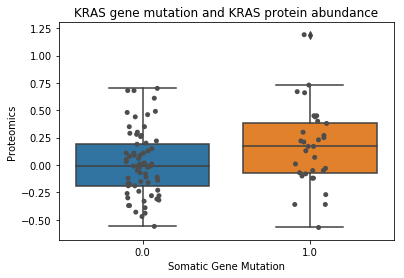

In [65]:
somatic_boxplot = sns.boxplot(data=cross, x=gene ,y=proteindfName)
somatic_boxplot.set_title(gene + " gene mutation and " + protList[0] + " protein abundance")
somatic_boxplot = sns.stripplot(data=cross, x=gene, y=proteindfName,jitter=True, color=".3")
somatic_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Proteomics")

### Protein phosphorylation levels and Protein Mutation

In [67]:
#Specify the gene and a general pattern for the sites you want to capture
#In this case, we want all the sites that begin with 'TP53'
sites = phos.filter(regex='KRA')
sigResults = [];

#Create two dataframes: mutated and non-mutated with the sites specified
genedf = somatic_mutations[gene].to_frame()
cross = genedf.add(sites, fill_value=0)
mutated = cross.loc[cross[gene] == 1.0]
wt = cross.loc[cross[gene] == 0.0]

#Bonferroni correction for multiple tests (we are testing multiple sites)
pcutoff = 0.05/len(cross.columns)
pcutoff = 1

#Loop through all of the sites found and print out the ones with significant p-values
for loc in cross.columns:
    if not loc == gene:
        mutsitedf = mutated[[gene, loc]].dropna()
        wtsitedf = wt[[gene, loc]].dropna()
        ttest = scipy.stats.ttest_ind(mutsitedf[loc], wtsitedf[loc])
        if ttest[1] <= pcutoff:
            sigResults.append(loc)
            print('Results for ' + loc + ': ')
            print(ttest)

Results for PRKRA-S167: 
Ttest_indResult(statistic=0.42232529520087925, pvalue=0.6740461053546318)
Results for PRKRA-S18: 
Ttest_indResult(statistic=2.161826227640993, pvalue=0.033066478253749906)


### We see that this site is generally phosphorylated at higher levels when TP53 is mutated

[Text(0,0.5,'Phosphoproteomics'), Text(0.5,0,'Somatic Gene Mutation')]

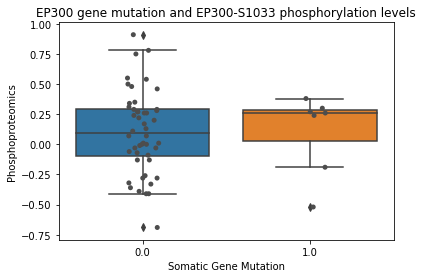

In [36]:
#sigResults is a list with all of the significant sites from the previous calculation (in this case there is only 1).
#Specify the index of the site you wish to visualize with x

x = 0
somatic_boxplot = sns.boxplot(data=cross, x=gene ,y=sigResults[x])
somatic_boxplot.set_title(gene + " gene mutation and " + sigResults[x] + " phosphorylation levels")
somatic_boxplot = sns.stripplot(data=cross, x=gene, y=sigResults[x],jitter=True, color=".3")
somatic_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Phosphoproteomics")